In [39]:
import sys
sys.path.append('..')
import h5py
import functions.data_class as data_class
import functions.plot as plot
import matplotlib.pyplot as plt
import importlib
import numpy as np
importlib.reload(plot)
importlib.reload(data_class)
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Polygon
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [114]:
%config InlineBackend.figure_format = 'svg'

In [115]:
%%html
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>

In [175]:
# statistic tests output
proj_12 = '../statistic_test_result/fib_10000/proj_test_12.h5'
proj_13 = '../statistic_test_result/fib_10000/proj_test_13.h5'
mcf_12 = '../statistic_test_result/fib_10000/mcf_slope_test_12_10000.h5'
mcf_13 = '../statistic_test_result/fib_10000/mcf_slope_test_13_10000.h5'
dgf_12 = '../statistic_test_result/fib_10000/dgf_test_12_10000.h5'
dgf_13 = '../statistic_test_result/fib_10000/dgf_test_13_10000.h5'

In [176]:
p12 = data_class.read_data(proj_12)
p13 = data_class.read_data(proj_13)
m12 = data_class.read_data(mcf_12)
m13 = data_class.read_data(mcf_13)
d12 = data_class.read_data(dgf_12)
d13 = data_class.read_data(dgf_13)

In [ ]:
def normal(x:np.ndarray, mu: float, sig:float)->np.ndarray:
    """
        Normal distribution.
    """
    N = 1/np.sqrt(2*np.pi)
    N /= sig
    
    X = (x - mu)/sig
    X **= 2
    X /= -2
    
    return N * np.exp(X)

In [260]:
x1 = np.arange(14)
x2 = np.arange(13)

mean_number_of_para_proj_13 = [np.sum(p13['probability'][i] * p13['n_para_proj'][i]) for i in range(14)]
mean_number_of_para_proj_12 = [np.sum(p12['probability'][i] * p12['n_para_proj'][i]) for i in range(13)]

likeli_para_proj_13 = p13['probability'][:,5]/np.max(p13['probability'][:,5])
likeli_para_proj_12 = p12['probability'][:,6]/np.max(p12['probability'][:,6])

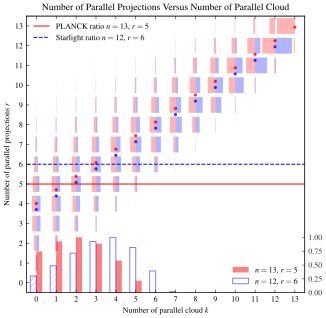

In [212]:
importlib.reload(plot)
plot.plot_statistic_test_discrete(
    x1=x1, y1=mean_number_of_para_proj_13,li1=likeli_para_proj_13, 
    bar_coord1=x1, prob1=p13['probability'], obs1= 5,
    x2=x2, y2=mean_number_of_para_proj_12,li2=likeli_para_proj_12, 
    bar_coord2=x2, prob2=p12['probability'], obs2= 6,
    xlim=(-0.5, 13.5), ylim=(-0.5, 13.5), bottom_scale=0.2,
    xlabel='Number of parallel cloud $k$', ylabel="Number of parallel projections $r$",
    title="Number of Parallel Projections Versus Number of Parallel Cloud",
    likeli_label1="$n=13$, $r=5$", likeli_label2="$n=12$, $r=6$",
    obs_label1="PLANCK ratio $n=13$, $r=5$", 
    obs_label2="Starlight ratio $n=12$, $r=6$")
    

In [121]:
def plot_fig_2(f1, y1, li1, bar1, prob1, f2, y2, li2, bar2, prob2, obs1, obs2):
    """
    plot test 2 result.
    """
    
    fig, ax1 = plt.subplots()
    
    # Line plot with error bar
    # ax1.errorbar(f1, y1, yerr = sd1, capsize=10, color = 'red')
    # ax1.errorbar(f2, y2, yerr = sd2, capsize=10, color = 'blue')
    ax1.plot(f1, y1, color = 'red' , marker = 'o', fillstyle = 'full', alpha = 0.7, markersize = 5)
    ax1.plot(f2, y2, color = 'blue', marker = 'o', fillstyle = 'none', alpha = 0.7, markersize = 5)


    # Horizontal line for observation.
    ax1.hlines(obs1, -1, 14,  color = 'red', ls = 'solid', label = r"PLANCK ratio: $n =13$, $r = 5$")
    ax1.hlines(obs2, -1, 14,  color = 'blue', ls = 'dashed', label = r"Optical ratio: $n =12$, $r = 6$")
    
    # Vertical plot 
    prob1 /= np.max([np.max(prob1), np.max(prob2)])
    prob2 /= np.max([np.max(prob1), np.max(prob2)])
    
    for i, prob in enumerate(prob1):
        plot_vd_cont(ax1, i, bar1, prob, 0.5, dir = 'l', color = 'red', w = 0.01, alpha = 0.5)

    for i, prob in enumerate(prob2):
        plot_vd_cont(ax1, i, bar2, prob, 0.5, dir = 'r', color = 'blue', w = 0.01, alpha = 0.3)
    
    
    
    # legend.
    ax1.legend(loc = 'upper right')
    
    # other setting.
    ax1.set_title("Relative MCF Difference for Different Number of Parallel Clouds")
    ax1.set_ylabel("Relative MCF difference $(R)$")
    ax1.set_xlabel("Number of parallel clouds ($k$)")
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(-0.7, 13.7)
    ax1.set_xticks(np.arange(0, 14), ["%d"%i for i in np.arange(0, 14)])
    # ax1.set_yticks(np.linspace(-0.6, 0.6, 13), ["%.1f"%i for i in np.linspace(-0.6, 0.6, 13)])
    
    
    # small plot for likelihood
    ax2 = ax1.twinx()

    # bar plot for likelihood function    
    w = 0.6

    ax2.bar(f1+w/4, 0.4*li1 , label = "$n = 13, r = 5$", width = w/2, color = 'red', alpha = 0.5)
    ax2.bar(f2-w/4, 0.4*li2 , label = "$n = 12, r = 6$", width = w/2, edgecolor = 'blue', alpha = 0.5, fill = False, hatch = '////', )
    
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.linspace(0, 0.4, 6), labels = ['%.2f' % i for i in np.linspace(0, 1, 6)])
    ax2.legend(loc = 'lower right', ncol = 1)
    ax2.set_ylabel("Relative Likelihood Function", labelpad = 10, loc = 'bottom')
    
    
    # plt.savefig("../images/mcf_slope.png", dpi = dpi)
    plt.show()

In [288]:

x1 = np.arange(14)
x2 = np.arange(13)

mean_mcf_slope_different_13 = [np.nanmean(m13['result'][i]) for i in range(14)]
mean_mcf_slope_different_12 = [np.nanmean(m12['result'][i]) for i in range(13)]

mcf_kde13 = [st.gaussian_kde(m13['result'][i][~np.isnan(m13['result'][i])]) for i in range(14)]
mcf_kde12 = [st.gaussian_kde(m12['result'][i][~np.isnan(m12['result'][i])]) for i in range(13)]

# from "../observations/read_observation.ipynb"
planck_mcf_mean = 0.30980160604629208843
planck_mcf_std = 0.10110408944998323932
optical_mcf_mean = 0.25598335067637884022
optical_mcf_std = 0.11532147170719482532

bar = np.linspace(-0.8, 0.92, 2000)


# Calculate by the observation distribution
planck_mcf = normal(bar, planck_mcf_mean, planck_mcf_std)
optical_mcf = normal(bar, optical_mcf_mean, optical_mcf_std)
likeli_mcf_slope_diff_13 = np.array([np.sum(k.pdf(bar)*planck_mcf) for k in mcf_kde13])
likeli_mcf_slope_diff_12 = np.array([np.sum(k.pdf(bar)*optical_mcf) for k in mcf_kde12])

# calculate by the mean observation data
# likeli_mcf_slope_diff_13 = np.array([k.pdf(planck_mcf_mean)[0] for k in mcf_kde13])
# likeli_mcf_slope_diff_12 = np.array([k.pdf(optical_mcf_mean)[0] for k in mcf_kde12])

likeli_mcf_slope_diff_13 /= np.max(likeli_mcf_slope_diff_13)
likeli_mcf_slope_diff_12 /= np.max(likeli_mcf_slope_diff_12)

prob_mcf_slope_diff_13 = [k.pdf(bar) for k in mcf_kde13]
prob_mcf_slope_diff_12 = [k.pdf(bar) for k in mcf_kde12]

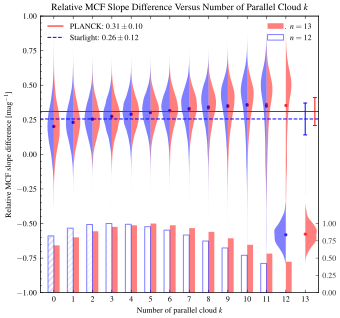

In [293]:
importlib.reload(plot)

plot.plot_statistic_test_continues(
    x1=x1, y1=mean_mcf_slope_different_13, li1=likeli_mcf_slope_diff_13,
    prob1=prob_mcf_slope_diff_13, bar_coord1=bar, obs1=planck_mcf_mean,
    x2=x2, y2=mean_mcf_slope_different_12, li2=likeli_mcf_slope_diff_12,
    prob2=prob_mcf_slope_diff_12, bar_coord2=bar, obs2=optical_mcf_mean,
    xlim=(-.7, 13.7), ylim=(-1,1), bottom_scale=0.25, obs1_std=planck_mcf_std,
    obs2_std=optical_mcf_std,
    xlabel='Number of parallel cloud $k$',
    ylabel="Relative MCF slope difference [mag$^{-1}$]",
    title="Relative MCF Slope Difference Versus Number of Parallel Cloud $k$",
    obs_label1=f"PLANCK: ${planck_mcf_mean:.2f} \pm {planck_mcf_std:.2f}$",
    obs_label2=f"Starlight: ${optical_mcf_mean:.2f} \pm {optical_mcf_std:.2f}$",
    likeli_label1="$n=13$", likeli_label2="$n=12$"
)

In [295]:
mean_dgf_diff_13 = [np.nanmean(d13['result'][i]) for i in range(14)]
mean_dgf_diff_12 = [np.nanmean(d12['result'][i]) for i in range(13)]

dgf_kde13 = [st.gaussian_kde(d13['result'][i][~np.isnan(d13['result'][i])]) for i in range(14)]
dgf_kde12 = [st.gaussian_kde(d12['result'][i][~np.isnan(d12['result'][i])]) for i in range(13)]

# from "../observations/read_observation.ipynb"
planck_dgf_mean = -0.84750463013795462874
planck_dgf_std = 0.27234865847532124805
optical_dgf_mean = -0.73118733558613902002
optical_dgf_std = 0.27578346005628745496

bar_dgf = np.linspace(-4, 2, 2000)

# distribution of the observation
planck_dgf = normal(bar_dgf, planck_dgf_mean, planck_dgf_std)
optical_dgf = normal(bar_dgf, optical_dgf_mean, optical_dgf_std)

likeli_dgf_diff_13 = np.array([np.sum(k.pdf(bar_dgf)*planck_dgf) for k in dgf_kde13])
likeli_dgf_diff_12 = np.array([np.sum(k.pdf(bar_dgf)*optical_dgf) for k in dgf_kde12])

likeli_dgf_diff_13 /= np.max(likeli_dgf_diff_13)
likeli_dgf_diff_12 /= np.max(likeli_dgf_diff_12)

prob_dgf_diff_13 = [k.pdf(bar_dgf) for k in dgf_kde13]
prob_dgf_diff_12 = [k.pdf(bar_dgf) for k in dgf_kde12]

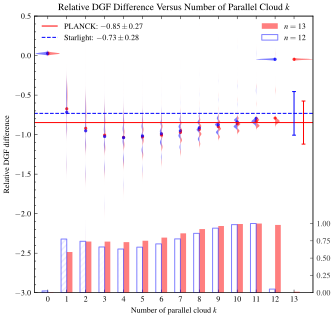

In [297]:
importlib.reload(plot)

plot.plot_statistic_test_continues(
    x1=x1, y1=mean_dgf_diff_13, li1=likeli_dgf_diff_13,
    prob1=prob_dgf_diff_13, bar_coord1=bar_dgf, obs1=planck_dgf_mean,
    x2=x2, y2=mean_dgf_diff_12, li2=likeli_dgf_diff_12,
    prob2=prob_dgf_diff_12, bar_coord2=bar_dgf, obs2=optical_dgf_mean,
    xlim=(-.7, 14), ylim=(-3,0.5), bottom_scale=0.25, obs1_std=planck_dgf_std,
    obs2_std=optical_dgf_std,
    xlabel='Number of parallel cloud $k$',
    ylabel="Relative DGF difference",
    vert_height=1,
    title="Relative DGF Difference Versus Number of Parallel Cloud $k$",
    obs_label1=f"PLANCK: ${planck_dgf_mean:.2f} \pm {planck_dgf_std:.2f}$",
    obs_label2=f"Starlight: ${optical_dgf_mean:.2f} \pm {optical_dgf_std:.2f}$",
    likeli_label1="$n=13$", likeli_label2="$n=12$"
)

In [298]:
likeli13_tot = likeli_para_proj_13*likeli_mcf_slope_diff_13*likeli_dgf_diff_13
likeli12_tot = likeli_para_proj_12*likeli_mcf_slope_diff_12*likeli_dgf_diff_12

likeli12_tot /= np.max(likeli12_tot)
likeli13_tot /= np.max(likeli13_tot)

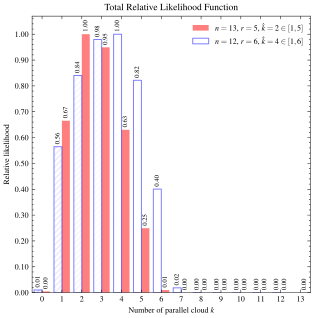

In [311]:
importlib.reload(plot)

plot.plot_likelihood(
    x1=np.arange(14), y1=likeli13_tot, 
    x2=np.arange(13), y2=likeli12_tot,
    ylabel="Relative likelihood",
    xlabel="Number of parallel cloud $k$",
    title="Total Relative Likelihood Function",
    label1="$n=13$, $r=5$, $\hat{k}=2 \in[1,5]$",
    label2="$n=12$, $r=6$, $\hat{k}=4\in[1,6]$"
)

In [315]:
likeli_p1p2_13 = likeli_para_proj_13*likeli_mcf_slope_diff_13
likeli_p1p2_12 = likeli_para_proj_12*likeli_mcf_slope_diff_12

likeli_p1p2_13 /= np.max(likeli_p1p2_13)
likeli_p1p2_12 /= np.max(likeli_p1p2_12)

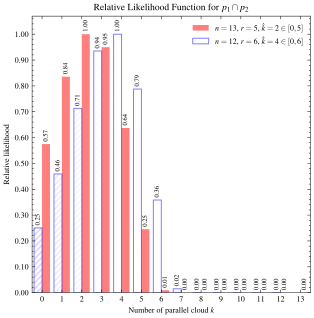

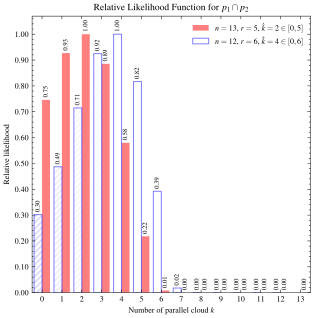

In [318]:
importlib.reload(plot)

plot.plot_likelihood(
    x1=np.arange(14), y1=likeli_p1p2_13, 
    x2=np.arange(13), y2=likeli_p1p2_12,
    ylabel="Relative likelihood",
    xlabel="Number of parallel cloud $k$",
    title="Relative Likelihood Function for $p_1 \cap p_2$",
    label1="$n=13$, $r=5$, $\hat{k}=2 \in[0,5]$",
    label2="$n=12$, $r=6$, $\hat{k}=4\in[0,6]$"
)

plot.plot_likelihood(
    x1=np.arange(14), y1=likeli_para_proj_13, 
    x2=np.arange(13), y2=likeli_para_proj_12,
    ylabel="Relative likelihood",
    xlabel="Number of parallel cloud $k$",
    title="Relative Likelihood Function for $p_1 \cap p_2$",
    label1="$n=13$, $r=5$, $\hat{k}=2 \in[0,5]$",
    label2="$n=12$, $r=6$, $\hat{k}=4\in[0,6]$"
)

In [323]:
likeli_p1p3_13 = likeli_para_proj_13*likeli_dgf_diff_13
likeli_p1p3_12 = likeli_para_proj_12*likeli_dgf_diff_12

likeli_p1p3_13 /= np.max(likeli_p1p3_13)
likeli_p1p3_12 /= np.max(likeli_p1p3_12)

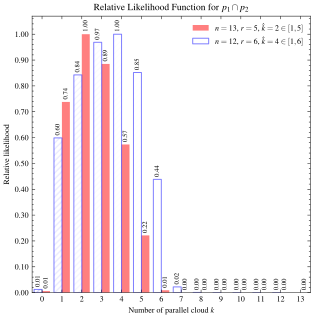

In [324]:
importlib.reload(plot)

plot.plot_likelihood(
    x1=np.arange(14), y1=likeli_p1p3_13, 
    x2=np.arange(13), y2=likeli_p1p3_12,
    ylabel="Relative likelihood",
    xlabel="Number of parallel cloud $k$",
    title="Relative Likelihood Function for $p_1 \cap p_2$",
    label1="$n=13$, $r=5$, $\hat{k}=2 \in[1,5]$",
    label2="$n=12$, $r=6$, $\hat{k}=4\in[1,6]$"
)